# 3A Relationships between Variables

So far, we have seen different ways to summarize and visualize _individual_ variables in a data set. But we have not really discussed how to summarize and visualize relationships between _multiple_ variables. This chapter is all about how to understand relationships between the columns in a `DataFrame`. The methods will be different, depending on whether the variables are categorical or quantitative.

# 3.1 Relationships between Categorical Variables

In this section, we look at ways to summarize the relationship between two _categorical_ variables. To do this, we will again use the Titanic data set.

In [2]:
%matplotlib inline
import pandas as pd

titanic_df = pd.read_csv("titanic.csv")

In [4]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Suppose we want to understand the relationship between where a passenger embarked and what class they were in. We can completely summarize this relationship by counting the number of passengers in each class that embarked at each location. We can create a pivot table that summarizes this information.

In [3]:
embarked_pclass_counts = titanic_df.pivot_table(
    index="embarked", columns="pclass",
    values="name",  # We can pretty much count any column, as long as there are no NaNs.
    aggfunc="count" # The count function will count the number of non-null values.
)
embarked_pclass_counts

pclass,1,2,3
embarked,,,
C,141,28,101
Q,3,7,113
S,177,242,495


A pivot table that stores counts is also called a **contigency table** or a **cross-tabulation**. This type of pivot table is common enough that there is a specific function in `pandas` to calculate one, allowing you to bypass `.pivot_table`:

In [5]:
counts = pd.crosstab(titanic_df.embarked, titanic_df.pclass)
counts

pclass,1,2,3
embarked,,,
C,141,28,101
Q,3,7,113
S,177,242,495


## Joint Distributions

It is common to normalize the counts in a table so that they add up to 1. These proportions represent the **joint distribution** of the two variables.

To calculate the joint distribution, we need to divide the table of counts above by the total count. To find the total count, we call `.sum()` twice; the first call gives us the sum of each column, and the second call adds those numbers together.

In [6]:
print(counts.sum().sum())
joint = counts / counts.sum().sum()
joint

1307


pclass,1,2,3
embarked,,,
C,0.107881,0.021423,0.077276
Q,0.002295,0.005356,0.086458
S,0.135425,0.185157,0.378730


Note that this is yet another example of broadcasting. When we divided the `DataFrame` `counts` by the number 1307, the division was applied elementwise, producing another `DataFrame`.

Each cell in this `DataFrame` tells us a joint proportion. For example, the cell in the bottom right tells us the proportion of all passengers that embarked at Southampton and were in 3rd class. We notate this joint proportion as follows:

$$ P(\text{embarked at Southampton and in 3rd class}) = .379. $$

The joint distribution above could also have been obtained by specifying `normalize=True` when the contingency table was first created:

In [7]:
pd.crosstab(titanic_df.embarked, titanic_df.pclass,
            normalize=True)

pclass,1,2,3
embarked,,,
C,0.107881,0.021423,0.077276
Q,0.002295,0.005356,0.086458
S,0.135425,0.185157,0.378730


The above joint distribution is not, strictly speaking, a contingency table. A contingency table is a table of all counts, while the above table is a table of proportions.

## Marginal Distributions

The **marginal distribution** of a variable is simply the distribution of that variable, ignoring the other variables. To calculate the marginal distribution from a joint distribution of two variables, we sum the rows or the columns of the joint distribution.

For example, to calculate the marginal distribution of `embarked`, we have to sum the joint distribution over the columns---in other words, _roll-up_ or _marginalize over_ the `pclass` variable:

In [8]:
joint.sum(axis=1)

embarked
C    0.206580
Q    0.094109
S    0.699311
dtype: float64

We can check this answer by calculating the distribution of `embarked` directly from the original data, ignoring `pclass` entirely.

In [9]:
embarked_counts = titanic_df.groupby("embarked")["name"].count()
embarked_counts / embarked_counts.sum()

embarked
C    0.206580
Q    0.094109
S    0.699311
Name: name, dtype: float64

The numbers match!

Likewise, we calculate the marginal distribution of `pclass` by summing the joint distribution over the rows---in other words, by _rolling-up_ or _marginalizing over_ the `embarked` variable:

In [10]:
joint.sum(axis=0)

pclass
1    0.245601
2    0.211936
3    0.542464
dtype: float64

So given the joint distribution of two categorical variables, there are two marginal distributions: one for each of the variables. These marginal distributions are obtained by summing the joint distribution table over the rows and over the columns.

The _marginal distribution_ is so-named because these row and column totals would typically be included alongside the joint distribution, in the _margins_ of the table. A contingency table with the marginal distributions included can be obtained by specifying `margins=True` in `pd.crosstab`:

In [11]:
pd.crosstab(titanic_df.embarked, titanic_df.pclass,
            normalize=True, margins=True)

pclass,1,2,3,All
embarked,,,,
C,0.107881,0.021423,0.077276,0.206580
Q,0.002295,0.005356,0.086458,0.094109
S,0.135425,0.185157,0.378730,0.699311
All,0.245601,0.211936,0.542464,1.000000


## Conditional Distributions

The **conditional distribution** tells us about the distribution of one variable, _conditional on_ the value of another. For example, we might want to know the proportion of 3rd class passengers that embarked at each location. In other words, what is the distribution of where a passenger embarked, _conditional on_ being in 3rd class?

If we go back to the contingency table:

In [12]:
embarked_pclass_counts

pclass,1,2,3
embarked,,,
C,141,28,101
Q,3,7,113
S,177,242,495


there were $101 + 113 + 495 = 709$ passengers in 3rd class, of whom 

- $101 / 709 = .142$ were embarked from city C,
- $113 / 709 = .159$ were embarked from city Q, and
- $495 / 709 = .698$ were embarked from city S.

We can calculate these proportions in code by dividing the `pclass=3` column by its sum:

In [13]:
embarked_pclass_counts[3] / embarked_pclass_counts[3].sum()

embarked
C    0.142454
Q    0.159379
S    0.698166
Name: 3, dtype: float64

Notice that these three proportions add up to 1, making this a proper distribution.

This conditional distribution helps us answer questions such as, "What proportion of 3rd class passengers embarked at Southampton?" We notate this conditional proportion as follows:

$$ P\big(\textrm{embarked at Southampton}\ \big|\ \textrm{in 3rd class}\big) = 0.698. $$

The pipe $\big|$ is read "given". So we are interested in the proportion of passengers who embarked at Southampton, _given_ that they were in 3rd class.

We could have also calculated this conditional distribution from the joint distribution (i.e., proportions instead of counts):

In [14]:
joint[3] / joint[3].sum()

embarked
C    0.142454
Q    0.159379
S    0.698166
Name: 3, dtype: float64

We have just calculated _one_ of the conditional distributions of `embarked`: the distribution conditional on being in 3rd class. There are two more conditional distributions of `embarked`: 

- the distribution conditional on being in 1st class 
- the distribution conditional on being in 2nd class

It is common to report _all_ of the conditional distributions of one variable given another variable.

Of course, it is straightforward to calculate these conditional distributions manually:

In [15]:
embarked_pclass_counts[1] / embarked_pclass_counts[1].sum()

embarked
C    0.439252
Q    0.009346
S    0.551402
Name: 1, dtype: float64

In [16]:
embarked_pclass_counts[2] / embarked_pclass_counts[2].sum()

embarked
C    0.101083
Q    0.025271
S    0.873646
Name: 2, dtype: float64

But there is a nifty trick for calculating all three conditional distributions at once. By summing the counts over `embarked`, we obtain the total number of people in each `pclass`:

In [17]:
pclass_counts = embarked_pclass_counts.sum(axis=0)
pclass_counts

pclass
1    321
2    277
3    709
dtype: int64

This is exactly what we need to divide each column of `embarked_pclass_counts` by:

In [18]:
embarked_given_pclass = embarked_pclass_counts.divide(pclass_counts, axis=1)
embarked_given_pclass

pclass,1,2,3
embarked,,,
C,0.439252,0.101083,0.142454
Q,0.009346,0.025271,0.159379
S,0.551402,0.873646,0.698166


(This is yet another example of _broadcasting_, since we are dividing a `DataFrame` by a `Series`.)

Compare each column with the numbers we obtained earlier. Notice also that each column sums to 1, a reminder that each column represents a separate distribution.

When comparing numbers across distributions, it is important to be careful. For example, the 87.4% and the 69.8% in the "Southampton" row represent percentages of different populations. Just because 87.4% is higher than 69.8% does not mean that more 2nd class passengers boarded at Southampton than 3rd class passengers. In fact, if we go back to the original contingency table, we see that more 3rd class passengers actually boarded at Southampton than 2nd class passengers!

There is also another set of conditional distributions for these two variables: the distribution of class, conditional on where they embarked. To calculate these conditional distributions, we instead divide `embarked_pclass_counts` by the sum of each row:

In [19]:
embarked_counts = embarked_pclass_counts.sum(axis=1)
pclass_given_embarked = embarked_pclass_counts.divide(embarked_counts, axis=0)
pclass_given_embarked

pclass,1,2,3
embarked,,,
C,0.522222,0.103704,0.374074
Q,0.024390,0.056911,0.918699
S,0.193654,0.264770,0.541575


These conditional distributions answer questions like, "What proportion of Southampton passengers were in 3rd class?" 

Notice that these proportions are _not_ the same as the proportions for the other set of conditional distributions. That is because the two questions below are fundamentally different:

_Question 1._ What proportion of 3rd class passengers embarked at Southampton?

$$P\big(\textrm{embarked at Southampton}\ \big|\ \textrm{in 3rd class}\big) = \frac{\text{# passengers who embarked at Southampton and in 3rd class}}{\text{# passengers who in 3rd class}}$$

_Question 2._ What proportion of Southampton passengers were in 3rd class? 

$$P\big(\textrm{in 3rd class}\ \big|\ \textrm{embarked at Southampton}\big) = \frac{\text{# passengers who embarked at Southampton and in 3rd class}}{\text{# passengers who embarked at Southampton}} \\ $$



In the first case, the reference population is all passengers who embarked at Southampton. In the second case, the reference population is all passengers who were in 3rd class. The numerators may be the same, but the denominators are different. In general, the conditional distributions of $X$ given $Y$ are _not_ the same as the conditional distributions of $Y$ given $X$. 

If we rephrase the question slightly, we get yet another answer:

_Question 3._ What proportion of passengers embarked at Southampton _and_ were in 3rd class?

$$P(\text{embarked at Southampton and in 3rd class}) = \frac{\text{# passengers who embarked at Southampton and in 3rd class}}{\text{# passengers (total)}}$$

The reference population here is all passengers. This is the proportion that one would get from the joint distribution.

It is important to pay attention to the wording of the question, to determine whether a joint distribution or a conditional distribution is called for---and, if the latter, which of the two conditional distributions is appropriate.

## Visualization

How do we visualize the joint and conditional distributions of two categorical variables? 

To visualize a joint distribution, we need to be able to represent three dimensions: two dimensions for the two categorical variables and a third dimension for the proportions. Although one option is a 3D graph, humans are not good at judging the sizes of 3D objects printed on a page. For this reason, **heat maps**, which use a color scale to represent the third dimension, are usually preferred. 

Unfortunately, heat maps are still not easy to create in `pandas`. We use the `seaborn` library to make a heat map:

<Axes: xlabel='pclass', ylabel='embarked'>

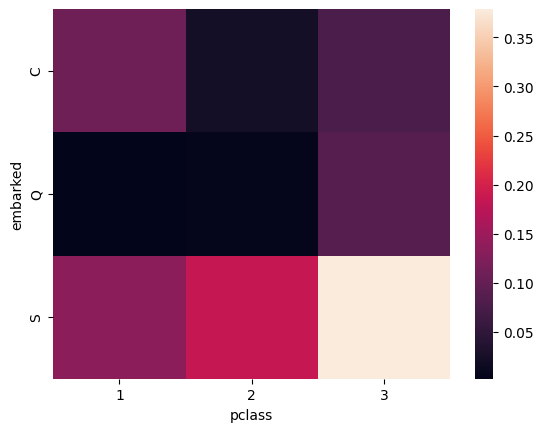

In [20]:
import seaborn as sns

sns.heatmap(joint)

A heat map encourages comparison across cells. So we see that 3rd class passengers who embarked at Southampton were by far the most common.

Although a heat map can also be used to visualize conditional distributions, it is not ideal because it does not tell us which variable we are conditioning on, and it is difficult to judge visually which dimension sums to 1. A stacked bar graph is better because it visually shows values summing to 1.

To make a stacked bar graph, we simply specify `stacked=True` in `.plot.bar()`, to get the bars to show up on top of one another, instead of side-by-side:

<Axes: xlabel='embarked'>

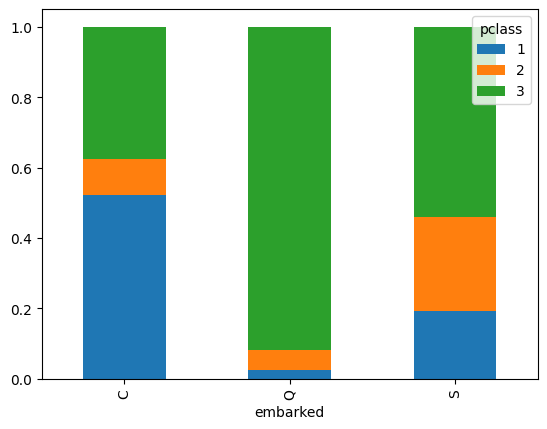

In [21]:
pclass_given_embarked.plot.bar(stacked=True)

However, the same code does not work on the other set of conditional distributions:

<Axes: xlabel='embarked'>

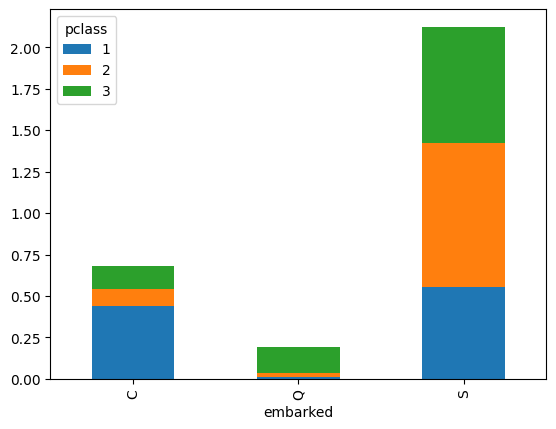

In [22]:
embarked_given_pclass.plot.bar(stacked=True)

What went wrong? Recall that `.plot.bar()` automatically plots the (row) index of the `DataFrame` on the $x$-axis. To plot the distribution of `embarked` conditional on `pclass`, we need `pclass` to be on the $x$-axis, but 

In [23]:
embarked_given_pclass

pclass,1,2,3
embarked,,,
C,0.439252,0.101083,0.142454
Q,0.009346,0.025271,0.159379
S,0.551402,0.873646,0.698166


has `embarked` as the index. To make `pclass` the index, we can **transpose** this `DataFrame` so that the rows become columns and the columns become rows. The syntax for transposing a `DataFrame` is `.T`, which is inspired by the notation for transposing a matrix in linear algebra.

In [24]:
embarked_given_pclass.T

embarked,C,Q,S
pclass,,,
1,0.439252,0.009346,0.551402
2,0.101083,0.025271,0.873646
3,0.142454,0.159379,0.698166


Now, we can make a stacked bar graph from this _transposed_ `DataFrame`:

<Axes: xlabel='pclass'>

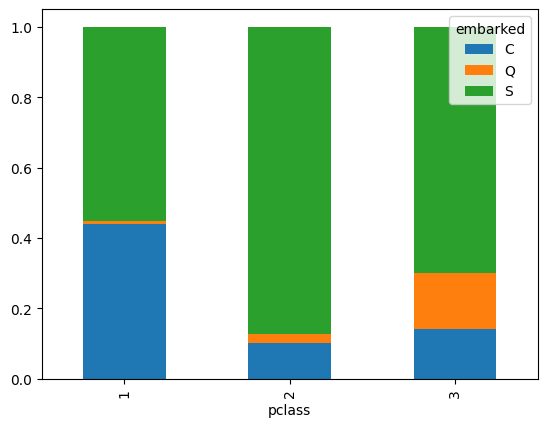

In [25]:
(embarked_given_pclass.T).plot.bar(stacked=True)

# Exercises

Exercises 1-4 deal with the Tips data set (`tips.csv`).

**Exercise 1.** Make a visualization that displays the relationship between the day of the week and party size.

In [42]:
# ENTER YOUR CODE HERE

df = pd.read_csv('tips.csv')

df

,obs,totbill,tip,sex,smoker,day,time,size
0,1,16.99,1.01,F,No,Sun,Night,2
1,2,10.34,1.66,M,No,Sun,Night,3
2,3,21.01,3.50,M,No,Sun,Night,3
3,4,23.68,3.31,M,No,Sun,Night,2
4,5,24.59,3.61,F,No,Sun,Night,4
...,...,...,...,...,...,...,...,...
239,240,29.03,5.92,M,No,Sat,Night,3
240,241,27.18,2.00,F,Yes,Sat,Night,2
241,242,22.67,2.00,M,Yes,Sat,Night,2
242,243,17.82,1.75,M,No,Sat,Night,2


In [38]:
df.head()

,obs,totbill,tip,sex,smoker,day,time,size
0,1,16.99,1.01,F,No,Sun,Night,2
1,2,10.34,1.66,M,No,Sun,Night,3
2,3,21.01,3.50,M,No,Sun,Night,3
3,4,23.68,3.31,M,No,Sun,Night,2
4,5,24.59,3.61,F,No,Sun,Night,4


In [43]:
contingency_table = pd.crosstab(df['day'], df['size'])

contingency_table

size,1,2,3,4,5,6
day,,,,,,
Fri,1,16,1,1,0,0
Sat,2,53,18,13,1,0
Sun,0,39,15,18,3,1
Thu,1,48,4,5,1,3


<Axes: xlabel='day'>

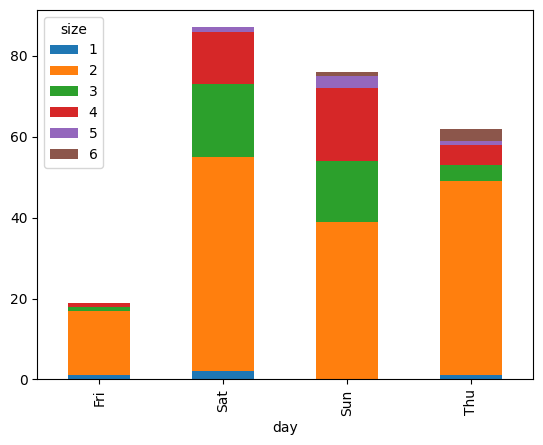

In [44]:
(contingency_table).plot.bar(stacked=True)

**Exercise 2.** Calculate the marginal distribution of day of week in two different ways.

In [45]:
# ENTER YOUR CODE HERE

marginal_table  = pd.crosstab(df['day'], df['size'], normalize=True, margins=True)

marginal_table

size,1,2,3,4,5,6,All
day,,,,,,,
Fri,0.004098,0.065574,0.004098,0.004098,0.000000,0.000000,0.077869
Sat,0.008197,0.217213,0.073770,0.053279,0.004098,0.000000,0.356557
Sun,0.000000,0.159836,0.061475,0.073770,0.012295,0.004098,0.311475
Thu,0.004098,0.196721,0.016393,0.020492,0.004098,0.012295,0.254098
All,0.016393,0.639344,0.155738,0.151639,0.020492,0.016393,1.000000


**Exercise 3.** Make a visualization that displays the conditional distribution of party size, given the day of the week.

In [47]:
# ENTER YOUR CODE HERE

conditional_table = pd.crosstab(df['day'], df['size'], normalize=1)

conditional_table

size,1,2,3,4,5,6
day,,,,,,
Fri,0.25,0.102564,0.026316,0.027027,0.0,0.00
Sat,0.50,0.339744,0.473684,0.351351,0.2,0.00
Sun,0.00,0.250000,0.394737,0.486486,0.6,0.25
Thu,0.25,0.307692,0.105263,0.135135,0.2,0.75


<Axes: xlabel='day'>

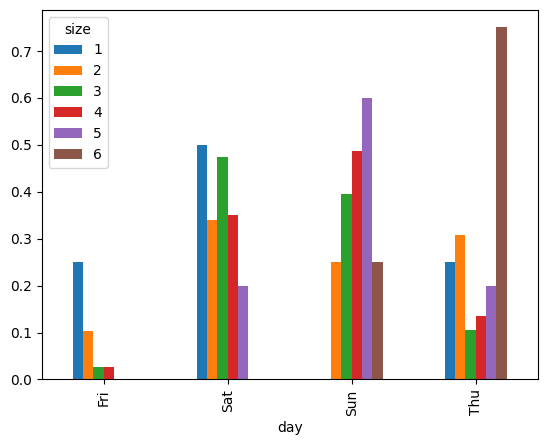

In [49]:
(conditional_table).plot.bar()

**Exercise 4.** What proportion of Saturday parties had 2 people? Is this the same as the proportion of 2-person parties that dined on Saturday?

In [ ]:
# ENTER YOUR CODE HERE

